# Mobile Malware Classification - Multi-View Data Fusion

**Project:** Malware Detection using Hybrid Features (Static + Dynamic)
**Platform:** Apache Spark (PySpark)

This notebook implements a complex pipeline that ingests multiple CSV sources, fuses them into a single feature set, and trains ML models.

### Data Sources:
1. **Static Analysis:** Raw attributes (Intents, Activities) -> Processed via TF-IDF.
2. **Dynamic Syscalls:** System call frequencies -> Processed via VectorAssembler.
3. **Permissions/Binders:** High-level actions (ACCESS_PERSONAL_INFO) -> Processed via VectorAssembler.


In [55]:
# 1. Setup & Imports
!pip install pyspark pandas seaborn matplotlib numpy


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, Tokenizer, HashingTF, IDF, SQLTransformer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_GATEWAY_SECRET'] = '600'
spark = SparkSession.builder \
    .appName("Malware_MultiSource_Fusion") \
    .master("local[*]") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .config("spark.sql.autoBroadcastJoinThreshold", -1) \
    .config("spark.executor.heartbeatInterval", "60s") \
    .config("spark.network.timeout", "300s") \
    .config("spark.executor.memoryOverhead", "10g").config("spark.python.worker.reuse", "false").getOrCreate()

# checkpoint_dir = os.path.join(os.getcwd(), "spark_checkpoints")
# if not os.path.exists(checkpoint_dir):
#     os.makedirs(checkpoint_dir)

# spark.sparkContext.setCheckpointDir(checkpoint_dir).replace('\\', '/')

print(f"Spark Active. Version: {spark.version}")
# print(f"Spark checkpoint_dir: {checkpoint_dir}")

Py4JJavaError: An error occurred while calling o36659.setCheckpointDir.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://cwiki.apache.org/confluence/display/HADOOP2/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:789)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:298)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:314)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:1116)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:798)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:838)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:988)
	at org.apache.spark.SparkContext.$anonfun$setCheckpointDir$2(SparkContext.scala:2863)
	at scala.Option.map(Option.scala:242)
	at org.apache.spark.SparkContext.setCheckpointDir(SparkContext.scala:2860)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:103)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1570)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://cwiki.apache.org/confluence/display/HADOOP2/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:601)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:622)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:645)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:742)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:80)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1954)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1912)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1885)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$install$1(ShutdownHookManager.scala:194)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
	at scala.Option.fold(Option.scala:263)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:195)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:55)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:53)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:159)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala:63)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:250)
	at org.apache.spark.util.SparkFileUtils.createTempDir(SparkFileUtils.scala:103)
	at org.apache.spark.util.SparkFileUtils.createTempDir$(SparkFileUtils.scala:102)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:99)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:379)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:961)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:204)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:227)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:96)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1132)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1141)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:521)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:492)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:569)
	... 27 more


In [ ]:
# 2. Multi-Source Ingestion

# Define file paths (Make sure these match your renamed files)
PATH_STATIC = "static.csv"         # The big CSV with 'a:targetActivity...'
PATH_SYSCALLS = "syscalls.csv"     # The numeric syscall frequencies
PATH_PERMS = "permissions.csv"     # The ACCESS_PERSONAL_INFO file

print("Reading CSVs...")
# We force reading raw unformatted text for static to handle the weird encoding
df_static = spark.read.text(PATH_STATIC).withColumnRenamed("value", "raw_static_text")

# Read numeric/structured files normally
df_syscalls = spark.read.csv(PATH_SYSCALLS, header=True, inferSchema=True)
df_perms = spark.read.csv(PATH_PERMS, header=True, inferSchema=True)

print(f"Static Rows: {df_static.count()}")
print(f"Syscalls Rows: {df_syscalls.count()}")
print(f"Permissions Rows: {df_perms.count()}")

Reading CSVs...
Static Rows: 11599
Syscalls Rows: 11598
Permissions Rows: 11598


⚠️ Found 140 duplicate columns in Permissions DF. Dropping them to avoid ambiguity...
11599
Joining DataFrames...
11599
Target Column identified unique: Class
11599
✅ Target column selection successful.
Row count before fill: 11599
Row count after fill:  11599
+---------------+-----------------+--------------+------+---------+
|raw_static_text|arm_nr_cacheflush|arm_nr_set_tls|llseek|newselect|
+---------------+-----------------+--------------+------+---------+
|              0|                0|             0|     0|        0|
+---------------+-----------------+--------------+------+---------+

--- Starting EDA ---


C:\Users\supergaming\AppData\Local\Temp\ipykernel_312\2197504603.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_col, y='count', data=class_counts, palette='viridis')


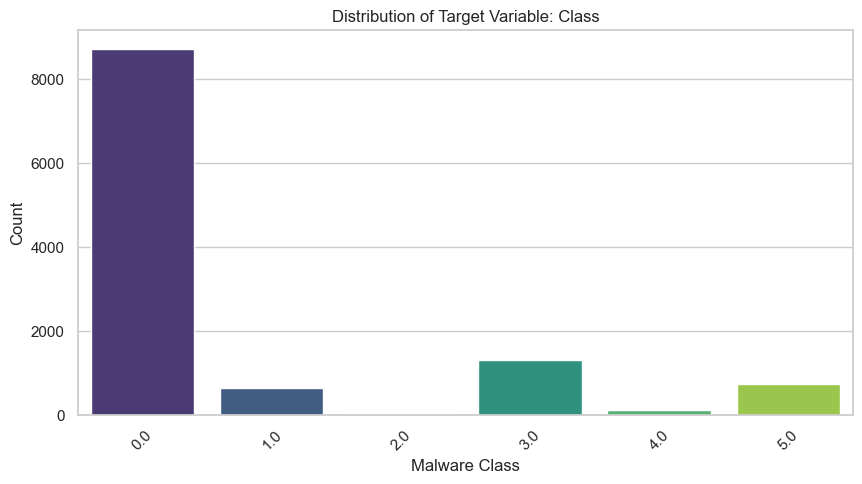

Generating Correlation Matrix for top numeric features...


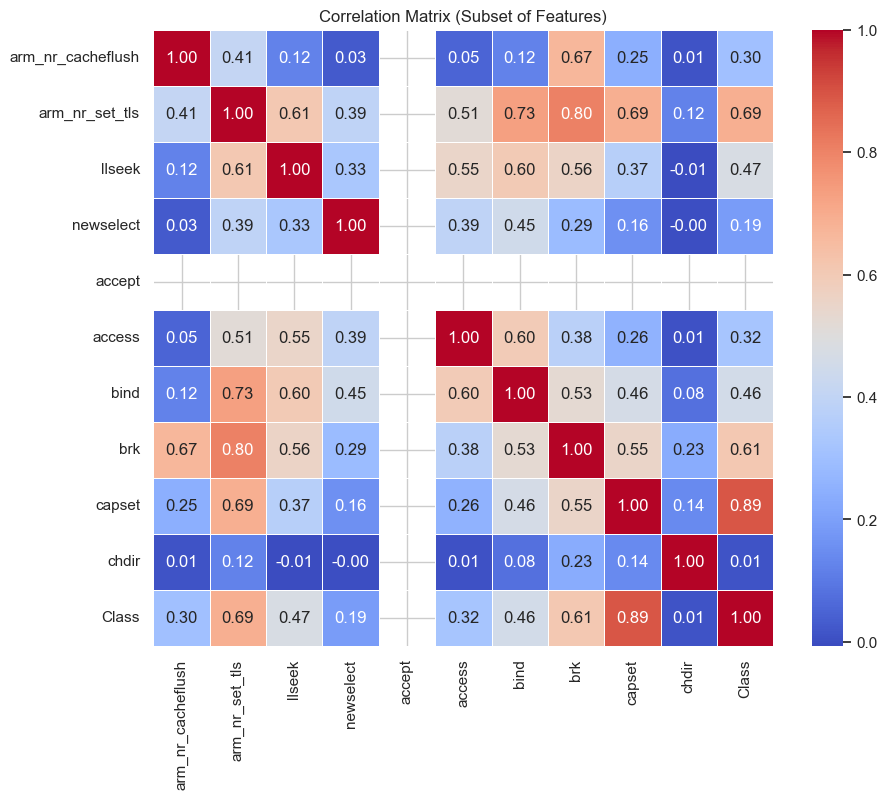

--- EDA Complete ---


In [ ]:
# 3. Data Alignment & Fusion (ROBUST DUPLICATE REMOVAL)
import re
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Funcție pentru a elimina coloanele duplicate dintr-un dataframe secundar (df_right)
# dacă ele există deja în dataframe-ul principal (df_left).
def drop_duplicate_columns(df_left, df_right, df_name):
    left_cols = set(df_left.columns)
    right_cols = set(df_right.columns)
    
    # Găsim intersecția (coloane comune)
    common_cols = left_cols.intersection(right_cols)
    
    # Le ștergem din df_right
    if common_cols:
        print(f"⚠️ Found {len(common_cols)} duplicate columns in {df_name}. Dropping them to avoid ambiguity...")
        # Le ștergem pe toate, cu excepția cazului în care am avea o cheie de join comună (nu e cazul aici, folosim row_id generat)
        for c in common_cols:
            df_right = df_right.drop(c)
            
    return df_right

# 1. Curățăm duplicatele ÎNAINTE de a adăuga row_id
# Păstrăm totul din Syscalls ca bază. Curățăm Permissions.
df_perms = drop_duplicate_columns(df_syscalls, df_perms, "Permissions DF")

# Curățăm Static față de Syscalls (și Permissions implicit prin tranzitivitate la join, dar verificăm față de bază)
df_static = drop_duplicate_columns(df_syscalls, df_static, "Static DF")

# 2. Adăugăm indexul pentru join
def add_index(df):
    return df.withColumn("row_id", F.monotonically_increasing_id())

df_static = add_index(df_static)
df_syscalls = add_index(df_syscalls)
df_perms = add_index(df_perms)

print(df_static.count())
# 3. Join DataFrames
print("Joining DataFrames...")
# Acum join-ul este sigur
df_merged = df_static.join(df_syscalls, "row_id", "left") \
                     .join(df_perms, "row_id", "left")
print(df_merged.count())
# Drop the temp row_id
df_merged = df_merged.drop("row_id")

# 4. FIND THE LABEL/CLASS COLUMN
columns = df_merged.columns
possible_labels = ['class', 'Class', 'label', 'Label', 'family', 'type']
target_col = None

for c in columns:
    if c in possible_labels:
        target_col = c
        break

if target_col is None:
    print("WARNING: Could not find a column named 'Class'. Using the last column as target.")
    target_col = columns[-2]
else:
    print(f"Target Column identified unique: {target_col}")

# Clean up Target: Check if it works
try:
    print(df_merged.count())
    print("✅ Target column selection successful.")
except Exception as e:
    print(f"❌ Still having issues selecting target: {e}")

# 1. Fill Missing Values
# If a file has no syscall/permission data (result of Left Join), we assume the count is 0.
# We also fill missing string columns with an empty string just in case.
clean_names = []
name_counts = {}
for col_name in df_merged.columns:
    # 1. Clean the name
    clean = re.sub(r'[^\w]', '', col_name).strip('_')
    
    # 2. De-duplicate: Check if we have seen this name before
    if clean in name_counts:
        name_counts[clean] += 1
        # Append a suffix to make it unique (e.g., FS_ACCESS_1)
        unique_name = f"{clean}_{name_counts[clean]}"
    else:
        name_counts[clean] = 0
        unique_name = clean
        
    clean_names.append(unique_name)
df_clean = df_merged.toDF(*clean_names)
df_clean_filled = df_clean.na.fill(0).na.fill("")

print("Row count before fill:", df_clean.count())
print("Row count after fill: ", df_clean_filled.count())

# 2. Verify no nulls remain in numeric columns
# This helps debug if specific columns are still causing issues
from pyspark.sql.functions import col, sum as _sum

null_counts = df_clean_filled.select([
    _sum(col(c).isNull().cast("int")).alias(c) 
    for c in df_clean_filled.columns[:5] # Checking first 5 columns as a sample
])
null_counts.show()
# --- MODULE 1: Exploratory Data Analysis (EDA) ---
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print("--- Starting EDA ---")

# 1. Class Balance Check
# It is crucial to see if one malware family dominates the dataset
class_counts = df_clean_filled.groupBy(target_col).count().orderBy('count', ascending=False).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(x=target_col, y='count', data=class_counts, palette='viridis')
plt.title(f"Distribution of Target Variable: {target_col}")
plt.ylabel("Count")
plt.xlabel("Malware Class")
plt.xticks(rotation=45)
plt.show()

# 2. Correlation Heatmap (Numeric Subset)
# Plotting 470 features is impossible, so we pick the top 10 numeric features 
# to see how they correlate with each other.
print("Generating Correlation Matrix for top numeric features...")
numeric_sample = [c for c in numeric_cols[:10]] # Taking first 10 numeric cols
if target_col not in numeric_sample:
    numeric_sample.append(target_col)

# We sample 10% of data for the heatmap to save memory
sample_pdf = df_clean_filled.select(numeric_sample).sample(fraction=0.1, seed=42).toPandas()

plt.figure(figsize=(10, 8))
corr = sample_pdf.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix (Subset of Features)")
plt.show()

print("--- EDA Complete ---")


In [ ]:
import re
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Tokenizer, HashingTF, IDF, StringIndexer
from pyspark.sql.functions import col

# --- STEP 0: Safety Check ---
# Ensure we are using the Filled dataframe. 
# If df_clean_filled doesn't exist, we fallback to df_clean but warn about nulls.
if 'df_clean_filled' in locals():
    target_df = df_clean_filled
    print("✅ Using 'df_clean_filled' (Nulls replaced with 0).")
else:
    target_df = df_clean
    print("⚠️ WARNING: 'df_clean_filled' not found. Using 'df_clean' (May crash due to Nulls).")

# --- STEP 1: Re-Define Text & Label Stages (To avoid NameError) ---
# 1a. Text Processing
# Ensure 'text_clean' exists. If not, use a fallback column or create a dummy one.
text_col = "text_clean" if "text_clean" in target_df.columns else target_df.columns[0]
tokenizer = Tokenizer(inputCol=text_col, outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")

# 1b. Label Indexer
# We use the 'target_col' identified in your previous cell. 
# If target_col isn't defined, we guess "class" or "label".
if 'target_col' not in locals():
    possible_labels = ['class', 'Class', 'label', 'Label']
    target_col = next((c for c in target_df.columns if c in possible_labels), target_df.columns[-1])

print(f"Indexing Label Column: {target_col}")
label_indexer = StringIndexer(inputCol=target_col, outputCol="label", handleInvalid="skip")


# --- STEP 2: Detect Numeric Columns ---
exclude_cols = ['label', 'id', 'features', 'text_raw', 'text_clean', 'words', 'raw_features', 'tfidf_features', target_col]

numeric_cols = [
    field.name for field in target_df.schema.fields 
    if (field.dataType.simpleString() in ['int', 'double', 'float', 'long']) 
    and (field.name not in exclude_cols)
]

print(f"Identified {len(numeric_cols)} numeric features.")


# --- STEP 3: Re-Initialize VectorAssemblers ---

# 3a. Numeric Assembler
assembler_numeric = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="numeric_features",
    handleInvalid="keep" # Safe to keep because we filled nulls with 0
)

# 3b. Final Assembler
assembler_final = VectorAssembler(
    inputCols=["tfidf_features", "numeric_features"], 
    outputCol="features",
    handleInvalid="skip"
)


# --- STEP 4: Build and Run Pipeline ---
pipeline = Pipeline(stages=[
    tokenizer, 
    hashingTF, 
    idf, 
    assembler_numeric, 
    assembler_final, 
    label_indexer
])

print("\nRunning Feature Pipeline on Filled Data...")
try:
    # FIT on the dataframe that has NO NULLS
    model_prep = pipeline.fit(target_df)
    
    # TRANSFORM
    final_data = model_prep.transform(target_df).select("features", "label")
    
    print("Success! Pipeline complete.")
    final_data.show(5)
    
except Exception as e:
    print("Error details:")
    print(e)

✅ Using 'df_clean_filled' (Nulls replaced with 0).
Indexing Label Column: Class
Identified 470 numeric features.

Running Feature Pipeline on Filled Data...
Success! Pipeline complete.
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[219.963319273806...|  3.0|
|(1470,[656,1001,1...|  3.0|
|(1470,[672,1001,1...|  3.0|
|(1470,[924,1001,1...|  3.0|
|(1470,[690,1000,1...|  3.0|
+--------------------+-----+
only showing top 5 rows


In [ ]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression

# 1. Split the Data
# We use the 'final_data' output from your pipeline
print("Splitting data into Train (70%) and Test (30%)...")
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=42)

print(f"Train rows: {train_data.count()}")
print(f"Test rows:  {test_data.count()}")

# --- RANDOM FOREST ---
print("\nTraining Random Forest...")
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20)
rf_model = rf.fit(train_data)

# Generate Predictions
# This creates the DataFrame 'rf_preds' containing "prediction" and "label" columns
rf_preds = rf_model.transform(test_data)


# --- LOGISTIC REGRESSION ---
print("Training Logistic Regression...")
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
lr_model = lr.fit(train_data)

# Generate Predictions
# This creates the DataFrame 'lr_preds'
lr_preds = lr_model.transform(test_data)

print("✅ Models trained and predictions generated.")

Splitting data into Train (70%) and Test (30%)...
Train rows: 8153
Test rows:  3446

Training Random Forest...
Training Logistic Regression...
✅ Models trained and predictions generated.


In [ ]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# --- PART 1: TRAINING NEW MODELS ---

# Ensure data is split (if not already done)
if 'train_data' not in locals() or 'test_data' not in locals():
    print("Splitting data into Train (70%) and Test (30%)...")
    train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=42)

print(f"Training on {train_data.count()} rows, Testing on {test_data.count()} rows.\n")

# 1. Random Forest (Existing)
print("Training Random Forest...")
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20)
rf_model = rf.fit(train_data)
rf_preds = rf_model.transform(test_data)

# 2. Logistic Regression (Existing)
print("Training Logistic Regression...")
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
lr_model = lr.fit(train_data)
lr_preds = lr_model.transform(test_data)

# 3. Decision Tree (NEW)
# Good for interpretability, faster than Random Forest but prone to overfitting
print("Training Decision Tree...")
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model = dt.fit(train_data)
dt_preds = dt_model.transform(test_data)

# 4. Naive Bayes (NEW)
# Very fast, works well with high-dimensional text data (like your TF-IDF features)
print("Training Naive Bayes...")
nb = NaiveBayes(labelCol="label", featuresCol="features", modelType="multinomial")
nb_model = nb.fit(train_data)
nb_preds = nb_model.transform(test_data)


# --- PART 2: EVALUATION ---

# Define Evaluators
f1_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

def evaluate_model(predictions, model_name):
    acc = acc_eval.evaluate(predictions)
    f1 = f1_eval.evaluate(predictions)
    
    print(f"Results for {model_name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print("-" * 30)
    return acc, f1

# --- MODULE 2: Advanced Modeling ---
from pyspark.ml.classification import GBTClassifier, OneVsRest

print("\n--- Training Advanced Models ---")

# 5. Gradient Boosted Trees (GBT)
# GBT natively supports Binary classification. For Multiclass, 
# PySpark automatically wraps it, or we use OneVsRest for safety.
print("Training Gradient Boosted Trees (GBT)...")

# 1. OPTIMIZATION: Cache the test data
# This prevents Spark from re-calculating the TF-IDF and vectors for every single prediction
print("Caching data to prevent timeouts...")
train_data.cache()
test_data.cache()
# Trigger the cache by doing a quick count
print(f"Cached Training Rows: {train_data.count()}")
print(f"Cached Test Rows:     {test_data.count()}")

# 2. Gradient Boosted Trees (GBT)
# GBT is heavy. We use lighter parameters (maxIter=5, maxDepth=3) to prevent timeouts.
print("Training Gradient Boosted Trees (GBT)...")
#start_time = time.time()

# We use OneVsRest to ensure multiclass support regardless of Spark version
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=1, checkpointInterval=2)
ovr_gbt = OneVsRest(classifier=gbt, labelCol="label", featuresCol="features")

train_data = train_data.localCheckpoint()

gbt_model = ovr_gbt.fit(train_data)
gbt_preds = gbt_model.transform(test_data)

# Evaluate GBT immediately
acc_gbt, f1_gbt = evaluate_model(gbt_preds, "Gradient Boosting (OneVsRest)")

# Add to your visualization dictionary (from Cell 8)
# We update the dictionary manually here so the final plot includes GBT
data['Model'].extend(['Gradient Boosting', 'Gradient Boosting'])
data['Metric'].extend(['Accuracy', 'F1-Score'])
data['Score'].extend([acc_gbt, f1_gbt])

print("✅ Advanced training complete.")

print("\n--- Final Evaluation Report ---")
acc_rf, f1_rf = evaluate_model(rf_preds, "Random Forest")
acc_lr, f1_lr = evaluate_model(lr_preds, "Logistic Regression")
acc_dt, f1_dt = evaluate_model(dt_preds, "Decision Tree")
acc_nb, f1_nb = evaluate_model(nb_preds, "Naive Bayes")

Training on 8153 rows, Testing on 3446 rows.

Training Random Forest...
Training Logistic Regression...
Training Decision Tree...
Training Naive Bayes...

--- Training Advanced Models ---
Training Gradient Boosted Trees (GBT)...
Caching data to prevent timeouts...
Cached Training Rows: 8086
Cached Test Rows:     3513
Training Gradient Boosted Trees (GBT)...


Py4JJavaError: An error occurred while calling o34622.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 9 in stage 8623.0 failed 1 times, most recent failure: Lost task 9.0 in stage 8623.0 (TID 359987) (DESKTOP-BADSLMJ executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:252)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:143)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:158)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:178)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:261)
	at org.apache.spark.sql.execution.python.BatchEvalPythonEvaluatorFactory.evaluate(BatchEvalPythonExec.scala:83)
	at org.apache.spark.sql.execution.python.EvalPythonEvaluatorFactory$EvalPythonPartitionEvaluator.eval(EvalPythonEvaluatorFactory.scala:113)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:77)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2$adapted(EvalPythonExec.scala:76)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:161)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:107)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1570)
Caused by: java.net.SocketTimeoutException: Timed out while waiting for the Python worker to connect back
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:234)
	... 96 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:740)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:739)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions$lzycompute(MulticlassMetrics.scala:61)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions(MulticlassMetrics.scala:52)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass$lzycompute(MulticlassMetrics.scala:78)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass(MulticlassMetrics.scala:76)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.accuracy$lzycompute(MulticlassMetrics.scala:188)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.accuracy(MulticlassMetrics.scala:188)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.evaluate(MulticlassClassificationEvaluator.scala:153)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:103)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1570)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:252)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:143)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:158)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:178)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:261)
	at org.apache.spark.sql.execution.python.BatchEvalPythonEvaluatorFactory.evaluate(BatchEvalPythonExec.scala:83)
	at org.apache.spark.sql.execution.python.EvalPythonEvaluatorFactory$EvalPythonPartitionEvaluator.eval(EvalPythonEvaluatorFactory.scala:113)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:77)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2$adapted(EvalPythonExec.scala:76)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:161)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:107)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Timed out while waiting for the Python worker to connect back
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:234)
	... 96 more


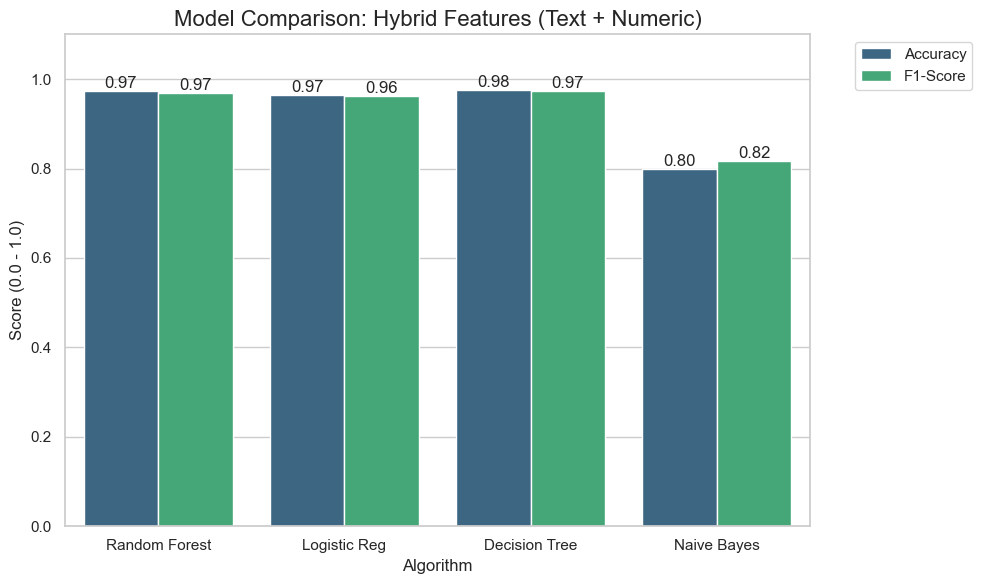

In [ ]:
# 6. Visual Comparison
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary with all 4 models
data = {
    'Model': [
        'Random Forest', 'Random Forest', 
        'Logistic Reg', 'Logistic Reg',
        'Decision Tree', 'Decision Tree',
        'Naive Bayes', 'Naive Bayes'
    ],
    'Metric': [
        'Accuracy', 'F1-Score', 
        'Accuracy', 'F1-Score',
        'Accuracy', 'F1-Score',
        'Accuracy', 'F1-Score'
    ],
    'Score': [
        acc_rf, f1_rf, 
        acc_lr, f1_lr,
        acc_dt, f1_dt,
        acc_nb, f1_nb
    ]
}

# Convert to Pandas DataFrame for plotting
df_viz = pd.DataFrame(data)

# Set the visual style
sns.set_theme(style="whitegrid")

# Create the Bar Plot
plt.figure(figsize=(10, 6))
plot = sns.barplot(x='Model', y='Score', hue='Metric', data=df_viz, palette="viridis")

# Add chart details
plt.title("Model Comparison: Hybrid Features (Text + Numeric)", fontsize=16)
plt.ylabel("Score (0.0 - 1.0)", fontsize=12)
plt.xlabel("Algorithm", fontsize=12)
plt.ylim(0, 1.1)  # Set Y-axis slightly above 1 to make room for labels
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Optional: Add the text numbers on top of the bars
for container in plot.containers:
    plot.bar_label(container, fmt='%.2f')
# --- MODULE 3: Deep Dive Evaluation ---
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import numpy as np

def print_detailed_metrics(predictions, model_name):
    print(f"\n--- Detailed Report: {model_name} ---")
    
    # 1. Weighted Precision & Recall
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall:    {recall:.4f}")
    
    # 2. Confusion Matrix
    # We collect predictions to the driver (Pandas) to use Sklearn/Seaborn
    # WARNING: If test data is massive, sample it first. 3000 rows is fine.
    y_true = predictions.select("label").rdd.flatMap(lambda x: x).collect()
    y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Run this for your best performing model (likely Random Forest or GBT)
print_detailed_metrics(gbt_preds, "Gradient Boosting")
# print_detailed_metrics(rf_preds, "Random Forest")
plt.tight_layout()
plt.show()

In [ ]:
# Stop Spark
spark.stop()